# Fisher information analysis

In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [2]:
mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

In [4]:
mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'


dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

basis_mode = 'eq'
C=2
model_dict = {
                'seed': 123, 
                'll_mode': f'U-{basis_mode}-{C}',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [-3, -2, -1, 0, 1, 2, 3], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

hd_sweep = torch.linspace(0, 2*np.pi, 100)
angles = np.linspace(0, 360, hd_sweep.shape[-1])

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

ll = lib.helper.RG_pred_ll(
                modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                ll_samples=1, cov_samples=1, beta=0.0)
print(f'delay {delay}, LL = {ll}')



rcov = dataset_dict['covariates']
sweep = torch.linspace(0, 2*torch.pi, 100)[None, :]
rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
units_used = dataset_dict['neurons']

covariates=hd_sweep[None, None, :, None]
with torch.no_grad():
        P_mc = lib.helper.marginalized_P(
        modelfit, sweep, [list(rcov.keys()).index('hd')],
                                         rcov_matrix, batch_size, list(range(units_used)),
                                         MC=30, skip=3)  # predictive posterior
P_mc = P_mc.cpu()


K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
hd_FF = hd_var / (hd_mean + 1e-12)

grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]

[fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])

[fisher_poisson] = utils.signal.percentiles_from_samples(torch.gradient(hd_rate, dim=2)[0]**2/  hd_rate, [0.5])
fisher_poisson *= dataset_dict['tbin']

units:  85  hdc units:  22
delay 0, LL = -202811.6908482143
99

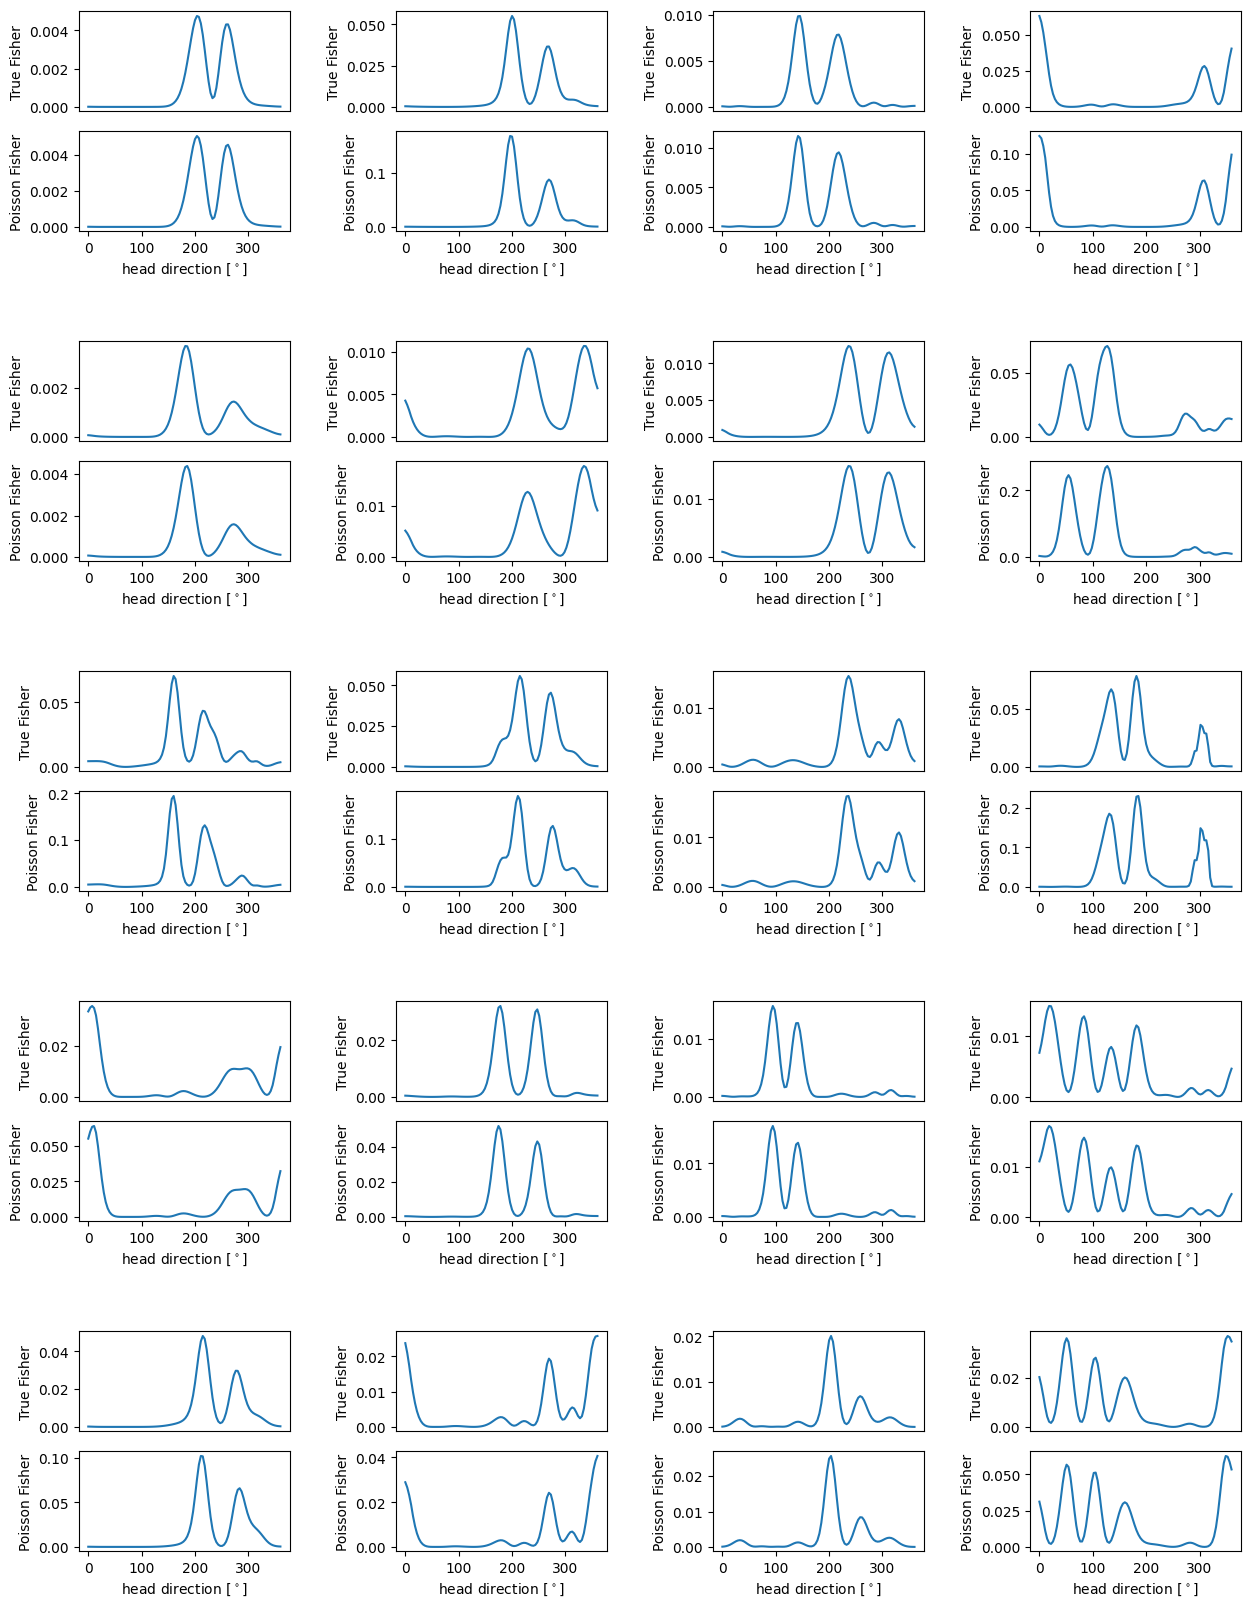

In [6]:
fig = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(5, 4, figure=fig, hspace=0.5, wspace=0.5)

for ne in np.arange(20):
    
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=spec[ne%5, ne//5])

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

    #ax[0, i].plot(angles, hd_rate[ne, :])
    #ax[1, i].plot(angles, hd_FF[ne, :])
    ax[0].plot(angles, fisher[ne, :])
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[1].plot(angles, fisher_poisson[ne, :])
    ax[1].set_xlabel('head direction [$^\circ$]')
    ax[1].set_ylabel('Poisson Fisher')
    ax[0].set_ylabel('True Fisher')

plt.tight_layout()

# Check if our neurons are almost Poisson

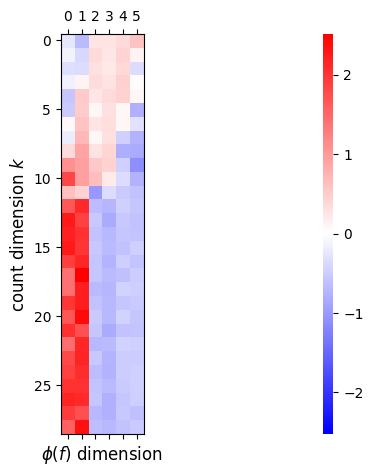

In [11]:
ne = 20  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())


fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
ax.set_xlabel(r'$\phi(f)$ dimension')
ax.set_ylabel(r'count dimension $k$')

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)
    
plt.show()

# Estimating Fisher information

Text(0.5, 0, 'head direction')

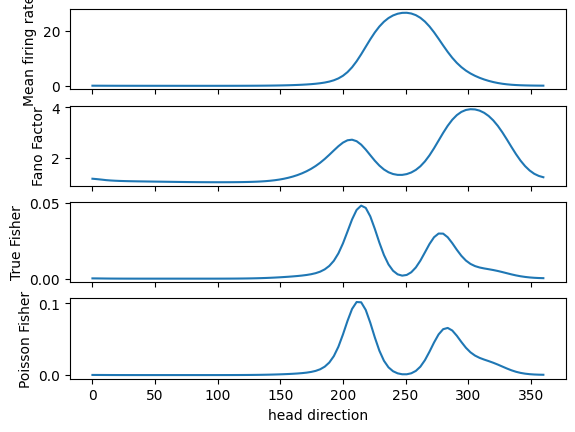

In [12]:
n = 4
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

[hd_rate_mean] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
[hd_FF_mean] = utils.signal.percentiles_from_samples(hd_FF, [0.5])

fig, ax = plt.subplots(4,1, sharex=True)

grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]


[fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])

[fisher_poisson] = utils.signal.percentiles_from_samples(torch.gradient(hd_rate, dim=2)[0]**2/  hd_rate, [0.5])
fisher_poisson *= dataset_dict['tbin']

#fisher /= (hd_sweep[1] - hd_sweep[0])

ax[0].plot(angles, hd_rate_mean[n, :])
ax[0].set_ylabel('Mean firing rate')
ax[1].plot(angles, hd_FF_mean[n])
ax[1].set_ylabel('Fano Factor')
ax[2].plot(angles, fisher[n])
ax[2].set_ylabel('True Fisher')
ax[3].plot(angles, fisher_poisson[n])
ax[3].set_ylabel('Poisson Fisher')
ax[3].set_xlabel('head direction')


Text(0, 0.5, 'number of neurons')

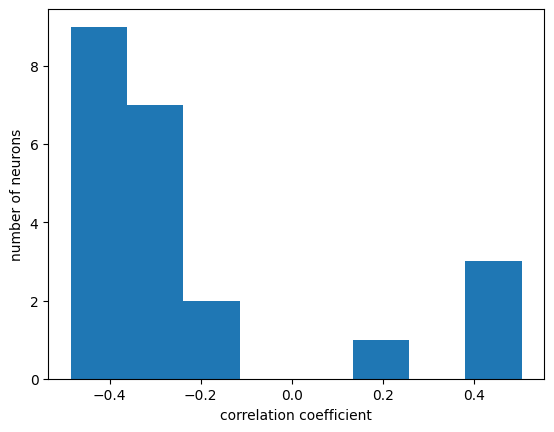

In [13]:
grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]

[fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])

correlations = np.empty((0,))
for ne in range(units_used):
    C = np.corrcoef(fisher[ne], hd_FF[ne])
    correlations = np.append(correlations, C[0,1])

fig, ax = plt.subplots()
ax.hist(correlations, bins='auto')
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('number of neurons')

# Different SCD distributions

In [14]:
from scipy.stats import norm

In [48]:
r_max = 10
s_preffered = np.pi
sigma_preffered = np.pi/4
T=1

def rate(s): 
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma_preffered) + 1

inputs = np.linspace(0, 2*np.pi, 100)
dtheta = inputs[1] - inputs[0]

r_avg = np.mean(rate(inputs))

def norm_constant(l, s, nu):
    const = 0
    for k in range(100):
        const += (l**k) / ((np.math.factorial(k))**nu)
    return const

def cm_poisson(r, s, nu=1): 
    """ Conway-Maxwell Poisson"""
    l = rate(s)/(rate(s)+1)
    norm_const = norm_constant(l, s, nu)
    return 1 / norm_const * (l**r) / ((np.math.factorial(r))**nu)

def manual_scd(r, s, sigma=0.1, left = 3*np.pi/4, right = 5*np.pi/4):
    if s > left and s < right:
        return 2 * rate(s) / (K*(K+1))
    m = rate(s)
    p = norm.cdf(r+1, loc=m, scale=sigma) - norm.cdf(r, loc=m, scale=sigma)
    return p

def geometric(r, s):
    p = 1 / (rate(s)+1)
    return p*(1-p)**r 

K = 29
rs = np.arange(0, K)
probs = np.empty((inputs.size, rs.size))
angles = inputs * 180 / np.pi

for i, r in enumerate(rs):
    for j, s in enumerate(inputs):
        probs[j, i] = cm_poisson(r, s, nu=0)
        #probs[j, i] = geometric(r, s)
        #probs[j, i] = manual_scd(r, s, sigma=1)

Text(0.5, 0, 'head direction')

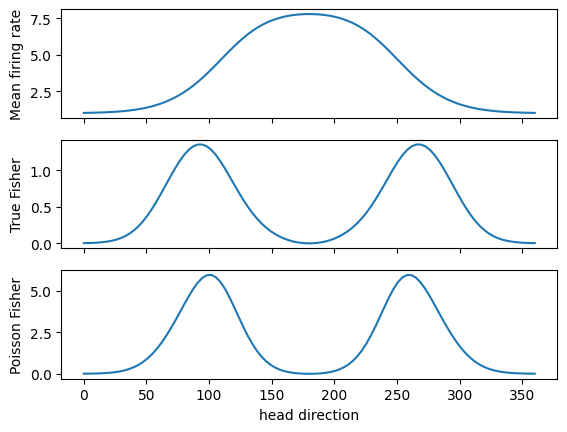

In [49]:
mean = (rs[None, :] * probs).sum(-1)
fisher_poisson = (np.gradient(mean) / dtheta)**2 / mean
grad = np.gradient(np.nan_to_num(np.log(probs), neginf=0.0), axis=0) / dtheta
fisher = (grad**2 * probs).sum(-1)

fisher[np.where(fisher > 100)] = np.nan

fig, ax = plt.subplots(3, 1, sharex=True)
#ax[0].set_title('Poisson distribution')
ax[0].plot(angles, mean)
ax[0].set_ylabel('Mean firing rate')
ax[1].plot(angles, fisher)
ax[1].set_ylabel('True Fisher')
ax[2].plot(angles, fisher_poisson)
ax[2].set_ylabel('Poisson Fisher')
ax[2].set_xlabel('head direction')


# Another way of calculating Fisher info

In [ ]:
with torch.no_grad():
    _, h = lib.helper.compute_P_with_derivatives(modelfit, covariates, list(range(dataset_dict['neurons'])), MC=30, trials=1)
h = h.cpu()

h_grad = torch.gradient(h, dim=-1)[0]
basis_grad_func = lib.models.get_basis_grad(basis_mode) 
basis_func = lib.models.get_basis(basis_mode)

MC = h.shape[0]
neurons = int(h.shape[1]/C)
steps = h.shape[2]
input = (h.permute(0,2,1)).reshape((MC*steps, neurons, C))
basis_grad = torch.cat([f_(input) for f_ in basis_grad_func], dim=-1)
basis = torch.cat([f_(input) for f_ in basis_func], dim=-1)

W = modelfit.likelihood.mapping_net.mnet.net[0].weight.data.cpu()
b = modelfit.likelihood.mapping_net.mnet.net[0].bias.data.cpu()

input_grad = (h.permute(0,2,1)).reshape((MC*steps, neurons, C))
expanded = torch.cat([input_grad, input_grad, input_grad], dim=-1)
F_grad = basis_grad * expanded


z_grad = (W[None, ...] * F_grad[..., None, :]).sum(-1)
z = (W[None, ...] * basis[..., None, :]).sum(-1) + b[None, ...]

zz_grad = z*z_grad
norm_vector = z_grad.sum(-1)

K = z.shape[-1]
zz_grad = torch.empty_like(z)
for i in range(K):
    zz_grad[...,i] = (z*z_grad[...,i][...,None]).sum(-1)    

zz_grad = zz_grad / norm_vector[..., None]


grad_p = ((z_grad - zz_grad).reshape(MC, steps, neurons, K)).permute(0,2,1,3)
#[fisher] = utils.signal.percentiles_from_samples((grad_p * P_mc).sum(-1), [0.5])